In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits 
import pandas as pd
from scipy.optimize import curve_fit
import scipy.stats as stats
import emcee
import corner

In [2]:
'''
读入数据
'''

hdu = fits.open('outerdisk_sample.fits')
header = hdu[1].header
data = hdu[1].data
#print(header)

源个数: 21553
半径范围: ( 9.00003315258531 , 19.975777116461135 )
视向速度范围: ( -386.14 , 312.19 )


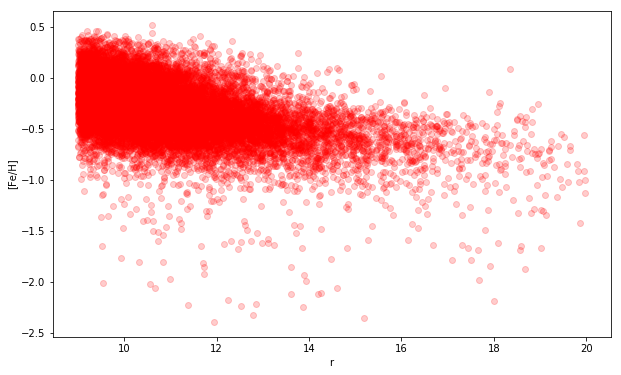

In [3]:
'''
取 9-20 kpc 内的源
'''

FeH = data.feh   # 金属丰度
FeH_err = data.feh_err   # 金属丰度误差
Rgc = data.Rgc   # 银心距
Rgc_err = [abs(i-8.34)*0.2 for i in Rgc]   # 银心距误差
RV = data.rv   # 视向速度


feh = []
feh_err = []
r = []
r_err = []
rv = []
for i in range(len(Rgc)):
    if (Rgc[i]<=20) & (Rgc[i]>=9):
        feh.append(FeH[i])
        feh_err.append(FeH_err[i])
        r.append(Rgc[i])
        r_err.append(Rgc_err[i])
        rv.append(RV[i])
    else:
        continue

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.plot(r, feh, 'ro', alpha=0.2)
ax.set_xlabel('r')
ax.set_ylabel('[Fe/H]')
print ('源个数:',len(feh))
print ('半径范围: (', min(r),',',max(r), ')')
print ('视向速度范围: (', min(rv),',',max(rv), ')')

In [4]:
'''
使用 curve_fit 初步检查丰度梯度
'''

def linear(x,a,b):
    return x*a+b

popt, pcov = curve_fit(linear, r, feh)
print('a=', popt[0], ',', 'b=', popt[1])
sigma_ab = np.sqrt(np.diag(pcov))
print('sigma_a=', sigma_ab[0], ',', 'sigma_b=', sigma_ab[1])

a= -0.07832751794698334 , b= 0.5382471865059612
sigma_a= 0.0009723404759374125 , sigma_b= 0.010746343209254786


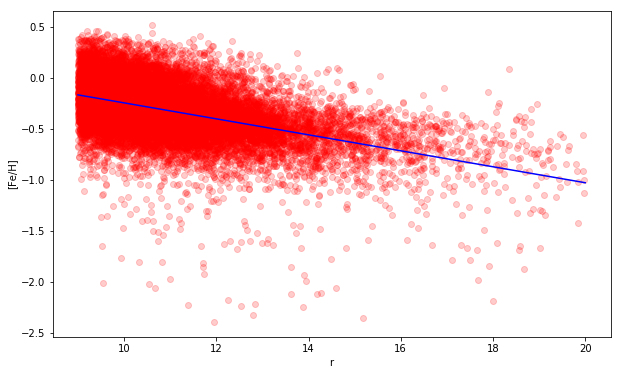

In [5]:
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.plot(r, feh, 'ro', alpha=0.2)
ax.set_xlabel('r')
ax.set_ylabel('[Fe/H]')

x_t = np.array([9,20])
y_t = popt[0]*x_t + popt[1]
ax.plot(x_t,y_t,'b')


本组源个数: 106
本组源个数: 1226
本组源个数: 7722
本组源个数: 10051
本组源个数: 2312
本组源个数: 136
0.53095675
0.27871585
0.2600746
0.24405806
0.25132883
0.5733091


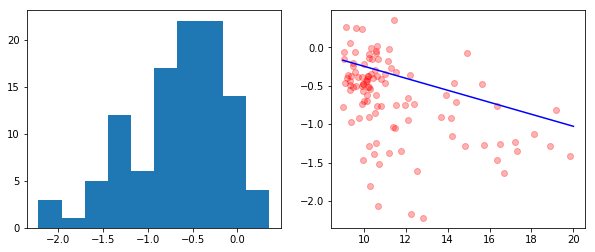

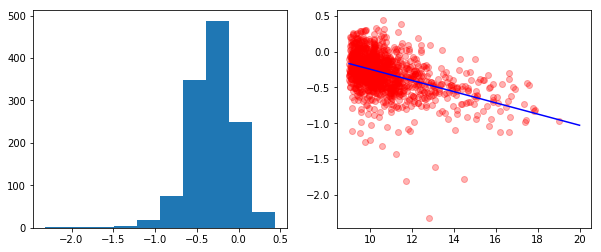

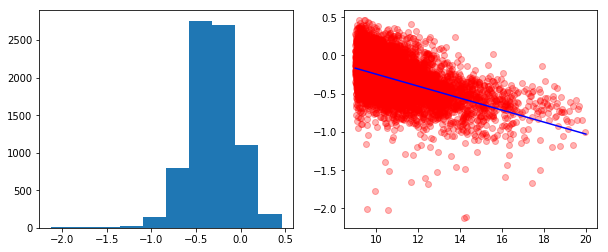

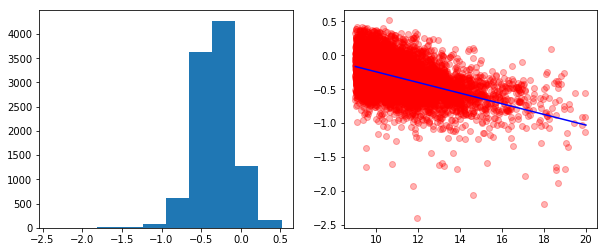

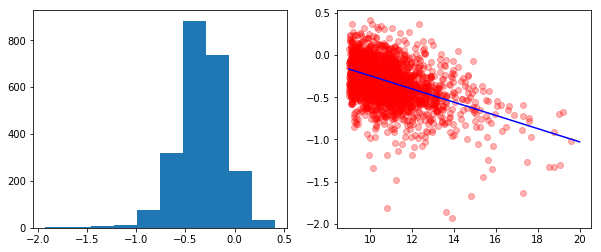

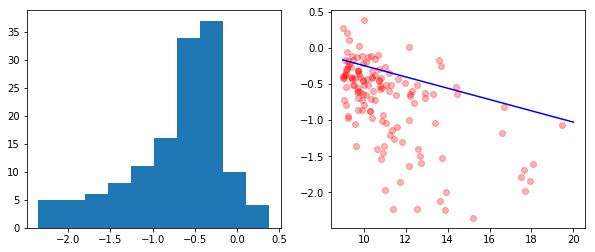

In [6]:
'''
按视向速度分组
'''

rgrid = [-400, -100, -50, 0, 50, 100, 400]
feh_group = []
r_group = []
for i in range(1,len(rgrid)):   # 分组长度比 rgrid （格点）长度少1.
    feh_group.append([])
    r_group.append([])
    for m in range(len(rv)):
        if (rv[m]<=rgrid[i]) & (rv[m]>rgrid[i-1]):
            feh_group[-1].append(feh[m])
            r_group[-1].append(r[m])
        else:
            continue
    print ('本组源个数:', len(feh_group[-1]))

for i in range(len(feh_group)):
    fig = plt.figure(figsize=[10,4])
    ax1 = fig.add_subplot(121)
    ax1.hist(feh_group[i],10)
    ax2 = fig.add_subplot(122)
    ax2.plot(r_group[i], feh_group[i], 'ro', alpha=0.3)
    ax2.plot(x_t,y_t,'b')
    print (np.std(feh_group[i]))
#fig.show()

In [7]:
import time
def p_y(y,r,a,b,sigma):
    ln_p = 0
    for i in range(len(y)):
        ln_p += np.log(stats.norm.pdf(y[i], loc=(a*r[i]+b), scale=sigma))
    #print(ln_p)
    return np.exp(ln_p)
#################################################################

'确实是没有归一化过的,我给了一个可以参考的归一化函数'
#################################################################

'''
使用拟合得到的值作为 a，b 的测试值
使用分组丰度分布 sigma 均值作为 本征sigma 测试值
取第一组数据（-400,-100）测试
'''

a_test = popt[0]
b_test = popt[1]
sigma_test = (np.std(feh_group[0])+np.std(feh_group[1])+np.std(feh_group[2])+np.std(feh_group[3]))/4

print (a_test, b_test, sigma_test)
start = time.clock()
print (p_y(feh_group[1], r_group[1], a_test, b_test, sigma_test))
elasped =(time.clock() - start)
print("Time used:",elasped,"second")

-0.07832751794698334 0.5382471865059612 0.3284513056278229
3.1738753315826975e-51
Time used: 0.1232359999999999 second


/Users/jing/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/jing/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [8]:
# 对数输入，做积分
# Please input array ln(p)
def Sum_for_ln(lnp):
    lnPeak = max(lnp)
    lnp = lnp - lnPeak
    #print(lnp)
    Psum = sum(np.exp(lnp))
    return (np.log(Psum)+lnPeak)


test_p = np.array([1,2,3,4,5,6])
ln_test = np.log(test_p)
print ("right answer:",sum(test_p))
print ("answer for test:", np.exp(Sum_for_ln(ln_test)))
# success

right answer: 21
answer for test: 21.0


In [9]:
import time
def ln_p_Mu_Sigma(theta, y_group, r_group):
    mu_a, mu_b, sig_a, sig_b, sigma = theta[0], theta[1], theta[2], theta[3], theta[4]
    if mu_a<-0.1 or mu_a>-0.05 or mu_b<0 or mu_b>1 or sig_a<0 or sig_a>1 or sig_b<0 or sig_b>1 or sigma<0.2 or sigma>0.6 :
        return -np.inf
    else:
        for j in range(len(y_group)):
            ln_p_ab = 0
            for k in range(10):
                pk = 0
                a = np.random.normal(loc=mu_a, scale=sig_a)
                b = np.random.normal(loc=mu_b, scale=sig_b)
                pk += p_y(y_group[j], r_group[j], a, b, sigma)
            #print(pk)
            ln_p_ab += np.log(pk)
        #print(ln_p_ab)
        return ln_p_ab

'''
使用拟合得到的值作为 a，b 及其 相应sigma 的测试值
使用分组丰度分布 sigma 均值作为 本征sigma 测试值
'''
start = time.clock()

data = [feh_group,r_group]
mu_a_test = popt[0]
mu_b_test = popt[1]
sig_a_test = sigma_ab[0]
sig_b_test = sigma_ab[1]
sigma_test = (np.std(feh_group[0])+np.std(feh_group[1])+np.std(feh_group[2])+np.std(feh_group[3]))/4
theta0 = [mu_a_test, mu_b_test, sig_a_test, sig_b_test, sigma_test]


print(ln_p_Mu_Sigma(theta0, feh_group, r_group))
elasped =(time.clock() - start)
print("Time used:",elasped,"second")

/Users/jing/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


-225.63946042199876
Time used: 18.11718 second


/Users/jing/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [10]:

nwalkers = 10
ndim = 5
p0=np.zeros((nwalkers,ndim))
p0[:,0] = mu_a_test
p0[:,1] = mu_b_test
p0[:,2] = sig_a_test
p0[:,3] = sig_b_test
p0[:,4] = sigma_test
    
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_p_Mu_Sigma, args=[feh_group, r_group])
pos, prob, state = sampler.run_mcmc(p0, 200)
sampler.reset()
sampler.run_mcmc(pos, 500)
samples = sampler.chain[:, :, :].reshape((-1, ndim))
figu = corner.corner(samples,labels=["$\mu_a$", "$\mu_b$", "$\sigma_a$", "$\sigma_b$", "$\sigma$"], quantiles=[0.16, 0.5, 0.84])


ValueError: Initial state has a large condition number. Make sure that your walkers are linearly independent for the best performance

In [ ]:
'''
nwalkers = 10
ndim = 5
p0=np.zeros((nwalkers,ndim))
p0[:,0] = mu_a_test
p0[:,1] = mu_b_test
p0[:,2] = sig_a_test
p0[:,3] = sig_b_test
p0[:,4] = sigma_test

from multiprocessing import Pool
import sys
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_p_Mu_Sigma, args=[feh_group, r_group])
    nsteps = 500
    width = 30
    for i, result in enumerate(sampler.sample(p0, iterations=nsteps)):
        z = int((width+1) * float(i) / nsteps)
        sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
figu = corner.corner(samples,labels=["$\mu_a$", "$\mu_b$", "$\sigma_a$", "$\sigma_b$", "$\sigma$"], quantiles=[0.16, 0.5, 0.84])
'''